In [64]:
#external libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt
import folium
from folium.plugins import TimestampedGeoJson
from datetime import datetime

import matplotlib as mpl
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [65]:
#local imports
from func.DataLoader import gdfLoader,ReadMarkerMap,RSSIDataLoader
from func.utils.getMarkerDictList import getMarkerDictList
from func.FoliumFeatureCreation.RawDataFeatures import RawDataFeatures
from func.MapCreation import MapCreation

In [66]:
MapDataPath="data/cartePalaiseau.csv"
ModuleMapPath="data/carteModulePalaiseau.csv"
Data_Path="data/manip1.1.csv"

saving_output=False

sampling_time=2000#ms #si supérieur à 2000ms il faut implémenter la moyenne dans la liste des rssi dans marker dict list

### Data loading


In [67]:
#Map Data
map_gdf=gdfLoader(MapDataPath)
map_gdf.to_crs(epsg=4326, inplace=True)
#marker data
marker_gdf=ReadMarkerMap(ModuleMapPath)
#rssi data
rssi_df=RSSIDataLoader(Data_Path)

pour tester la performance de notre modèle, on test de mettre moins de récepteurs pour voir comment notre système se comporte.

In [68]:
m=MapCreation(map_gdf,marker_gdf)
m

In [69]:
#MacModule à enlever

deleted_mac_module=['C45BBE39870E','A8032A311DAA','A8032A312052','C4BBE384CD2','C45BBE37B346','A8032A30FB9E','A8032A311F6A','A8032A311F96','A8032A31204E','C45BBE384CD2','C45BBE38FEAA']
def macModuleDeleter(marker_gdf,rssi_df,deleted_mac_module):
    for mac_module in deleted_mac_module:
        marker_gdf=marker_gdf[marker_gdf.macModule != mac_module]
    for mac_module in deleted_mac_module:
        rssi_df=rssi_df[rssi_df.macModule != mac_module]
    return marker_gdf,rssi_df
marker_gdf,rssi_df=macModuleDeleter(marker_gdf,rssi_df,deleted_mac_module)


In [70]:
m=MapCreation(map_gdf,marker_gdf)
m



In [71]:
#to optimize the getting of location of macModule, we create a dictionnary
MacModuleLocation = marker_gdf.set_index("macModule").to_dict()["geometry"]
#it display the approximation of point location in print but it is not the case in the dataframe

### Bind the received RSSI Data to the CartoModule Marker on Map

In [72]:
#create a list of timestamps between min_timestamp and max_timestamp with a step of sampling_time
min_timestamp=rssi_df.iloc[0]['timestamp']+pd.Timedelta(sampling_time, unit="ms")
max_timestamp=rssi_df.iloc[-1]['timestamp']
timestamp_list= pd.date_range(start=min_timestamp, end=max_timestamp, freq=str(sampling_time)+"ms").tolist()


In [73]:
MarkerDictList=getMarkerDictList(rssi_df, timestamp_list)

colormap creation

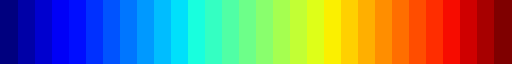

In [74]:
cmap = mpl.colormaps['jet'].resampled(30)
cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, 30)))
cmap

In [75]:
raw_data_features=RawDataFeatures(MarkerDictList,timestamp_list,MacModuleLocation,cmap)
MarkerLayer=TimestampedGeoJson(
                    {"type": "FeatureCollection","features": raw_data_features},
                    period='PT2S',
                    duration='PT1S',
                    transition_time=sampling_time,
                    auto_play=True)

In [76]:
m=MapCreation(map_gdf,marker_gdf)

MarkerLayer.add_to(m)
folium.LayerControl().add_to(m)
if saving_output:
    m.save('output/marker_map.html')
m

# implementation of low precision localisation

### 1. Naive implementation 

we're looking for 3 points at each sample,
if no 3 receivers received , we take the last 3 received,
if more than 3 receivers received we keep the 3 highest RSSI signal received

In [77]:
def max_marker_dict(marker_dict,edge_number=3):
    #keep only the edge_number modules with the highest rssi values
    #if there is less than edge_number modules, we keep all of them

    if len(marker_dict) > edge_number:
        # to do : function only if number of received signal for the module in list is 1 
        marker_dict={key: marker_dict[key] for key in sorted(marker_dict, key=marker_dict.get, reverse=True)[:edge_number]}
    return(marker_dict)
def getPolygonList(MarkerDictList,MacModuleLocation,min_edge_number=3,max_edge_number=3):
    #works with polygon with moe than 3 points but not with 3 points because it is not a convex polygon, should use convex hull
    list_of_list_of_points=[]
    for i in range(len(MarkerDictList)):
        marker_dict=MarkerDictList[i]
        list_of_points = []
        marker_dict=max_marker_dict(marker_dict,max_edge_number)
        for mac_module,rssi in marker_dict.items():
            list_of_points.append([MacModuleLocation[mac_module].x,MacModuleLocation[mac_module].y])
        
        count_backward=1
        while len(list_of_points) < min_edge_number and i-count_backward >= 0:

            points_to_add=3-len(list_of_points)
            marker_dict=MarkerDictList[i-count_backward]
            marker_dict=max_marker_dict(marker_dict,points_to_add)

            
            for mac_module,rssi in marker_dict.items():
                location=[MacModuleLocation[mac_module].x,MacModuleLocation[mac_module].y]
                if location in list_of_points:
                    continue
                list_of_points.append(location)
            count_backward+=1
        list_of_list_of_points.append(list_of_points)
    #eject the marker not having the right number of points ( not triangle for example)
    for index,list1 in enumerate(list_of_list_of_points):
        if len(list1)<min_edge_number:
            print("error")
            list_of_list_of_points.pop(index)
    return(list_of_list_of_points)
list_of_list_of_points=getPolygonList(MarkerDictList,MacModuleLocation,min_edge_number=3,max_edge_number=3)


error
error
error


list_of_list_of_points est une liste définissant les points associés aux 3 récepteurs les plus forts pour chaque temps. on cherche maintenant à afficher les polygones associés dans une map temporelle

In [78]:
def PolygonalFeatures(list_of_list_of_points,timestamp_list):
    input_format = '%Y-%m-%d %H:%M:%S.%f'
    output_format = '%Y-%m-%dT%H:%M:%S'
    features = []
    timestamp_list=[]
    for index in range(len(list_of_list_of_points)):
        timestamp = min_timestamp+index*pd.Timedelta(sampling_time, unit="ms")
        dt = datetime.strptime(str(timestamp), input_format)
        new_timestamp = dt.strftime(output_format)
        timestamp_list.append(new_timestamp)
    features = [{
        'type': 'Feature',
        'geometry': {
            'type': 'Polygon',
            'coordinates': list_of_list_of_points
        },
        'properties': {
            'times': timestamp_list,
            'style': {'color': 'red', 'weight': 1},
            
        }
    }]
    return features


In [79]:
polygonal_features=PolygonalFeatures(list_of_list_of_points,timestamp_list)



m = MapCreation(map_gdf,marker_gdf)


TimestampedGeoJson({"type": "FeatureCollection","features": polygonal_features},
                    period='PT2S',
                    duration='PT1S',
                    transition_time=sampling_time,  
                    auto_play=True).add_to(m)
folium.LayerControl().add_to(m)
m


In [80]:
def polygonlist_to_polygoncenterlist(list_of_list_of_points):
    centerList=[]
    for list1 in list_of_list_of_points:
        n=0
        xlist=0
        ylist=0
        for point in list1:    
            xlist+=point[0]
            ylist+=point[1]
            n+=1
        centerList.append([xlist/n,ylist/n])
    return(centerList)
centerList=polygonlist_to_polygoncenterlist(list_of_list_of_points)
        

In [81]:
centerList
for _center in centerList:
    if len(_center) != 2:
        print("error")

In [82]:
def CenterOfPolygonsFeatures(centerList,list_of_list_of_points,sampling_time):
    #different timestamp list
    input_format = '%Y-%m-%d %H:%M:%S.%f'
    output_format = '%Y-%m-%dT%H:%M:%S'
    timestamp_list=[]
    for index in range(len(list_of_list_of_points)):
        timestamp = min_timestamp+index*pd.Timedelta(sampling_time, unit="ms")
        dt = datetime.strptime(str(timestamp), input_format)
        new_timestamp = dt.strftime(output_format)
        timestamp_list.append(new_timestamp)
        
    center_of_polygons_features = [{
        'type': 'Feature',
        'geometry': {
            'type': 'MultiPoint',
            'coordinates': centerList
        },
        'properties': {
            'times': timestamp_list,
            "icon": 'circle',
            'style': {'color': 'red', 'weight': 1},
            
        }
    }]
    return(center_of_polygons_features)
center_of_polygons_features=CenterOfPolygonsFeatures(centerList,list_of_list_of_points,sampling_time)
m = MapCreation(map_gdf,marker_gdf)

TimestampedGeoJson(center_of_polygons_features,
                    period='PT2S',
                    duration='PT1S',
                    transition_time=sampling_time,  
                    auto_play=True).add_to(m)
folium.LayerControl().add_to(m)
if saving_output:
    m.save('output/map_with_point_locations.html')
m


In [83]:

import numpy as np
number_of_points=len(centerList)
longitude_data=np.empty(number_of_points)
latitude_data=np.empty(number_of_points)
for index,point in enumerate(centerList):
    longitude_data[index]=point[0]
    latitude_data[index]=point[1]
latitude_data,longitude_data

(array([48.71318499, 48.71318499, 48.71319403, 48.71318499, 48.71318499,
        48.71318499, 48.71318499, 48.71318499, 48.71318499, 48.71318499,
        48.71318499, 48.71316411, 48.71316411, 48.71315707, 48.71314222,
        48.71318499, 48.71318499, 48.71316411, 48.71316411, 48.71316411,
        48.71315707, 48.71315707, 48.71317092, 48.71316411, 48.71316411,
        48.71316411, 48.71316411, 48.71316411, 48.71316411, 48.71316411,
        48.7131621 , 48.7131621 , 48.7131621 , 48.7131621 , 48.7131621 ,
        48.7131621 , 48.7131621 , 48.7131621 , 48.7131621 , 48.7131621 ,
        48.71314021, 48.71313353, 48.71314739, 48.7131382 , 48.71314021,
        48.71314021, 48.71314021, 48.71314021, 48.71314021, 48.71314021,
        48.71314021, 48.71314021, 48.71314021, 48.71314021, 48.71314021,
        48.71314021, 48.71314035, 48.71314035, 48.71314035, 48.71314035,
        48.71314021, 48.71314739, 48.71313833, 48.71313833, 48.71313833,
        48.71313833, 48.71313833, 48.71313833, 48.7

In [84]:
def kalman_filter(data, Q, R):
    n = len(data)
    x_est = np.zeros(n)
    P = np.zeros(n)
    x_est[0] = data[0]
    P[0] = 1.0

    for i in range(1, n):
        x_pred = x_est[i-1]
        P_pred = P[i-1] + Q

        K = P_pred / (P_pred + R)
        x_est[i] = x_pred + K * (data[i] - x_pred)
        print("diff=",x_est[i]-x_pred)
        P[i] = (1 - K) * P_pred

    return x_est

Q = 30  # Process noise
R = 10  # Measurement noise


In [85]:
def movingaveragetechnique(data,n=3):
    '''
    filtering the data with moving average technique


    https://en.wikipedia.org/wiki/Moving_average
    '''
    
    return np.convolve(data, np.ones(n), 'full') / n

In [86]:
longitude_filtered = movingaveragetechnique(longitude_data,10)
latitude_filtered = movingaveragetechnique(latitude_data,10)
print(longitude_filtered)
centerList_filtered=np.vstack((longitude_filtered,latitude_filtered)).T.tolist()
#attention , problême ici, on a pas le même nombre de timestamp que de points
while len(timestamp_list)>len(centerList_filtered):
    timestamp_list.pop()
timestamp_list=[]
input_format = '%Y-%m-%d %H:%M:%S.%f'
output_format = '%Y-%m-%dT%H:%M:%S'
for index in range(len(list_of_list_of_points)):
    timestamp = min_timestamp+index*pd.Timedelta(sampling_time, unit="ms")
    dt = datetime.strptime(str(timestamp), input_format)
    new_timestamp = dt.strftime(output_format)
    timestamp_list.append(new_timestamp)
print(len(centerList_filtered),len(timestamp_list))
print(centerList_filtered)
print(timestamp_list)

[0.22006984 0.44013649 0.66020525 0.88027509 1.10034493 1.32041477
 1.54048461 1.76055445 1.98062429 2.20069413 2.20069413 2.20070828
 2.20072031 2.20073802 2.2007617  2.2007617  2.2007617  2.20077266
 2.20078361 2.20079456 2.20081227 2.20081903 2.20082028 2.20081352
 2.20080079 2.20081174 2.20082269 2.20082269 2.20082269 2.20082269
 2.20082457 2.20082644 2.20083382 2.20084244 2.20085107 2.2008597
 2.20086833 2.20087695 2.20088558 2.20089421 2.20090694 2.20092688
 2.20094132 2.20095808 2.20097081 2.20098354 2.20099627 2.201009
 2.20102173 2.20103446 2.20103446 2.20102724 2.20102553 2.2010215
 2.2010215  2.2010215  2.20102996 2.20103842 2.20104689 2.20105535
 2.20105535 2.20105706 2.20106956 2.20108206 2.20109456 2.20110706
 2.2011111  2.20111514 2.20111918 2.20112322 2.20114191 2.20115773
 2.20116105 2.20116407 2.20116407 2.20116879 2.20116879 2.20117381
 2.20118001 2.2011865  2.20118363 2.2011851  2.20117332 2.20116479
 2.20115928 2.20114734 2.20114013 2.20113107 2.20111237 2.20109337

In [87]:
features = [{
    'type': 'Feature',
    'geometry': {
        'type': 'MultiPoint',
        'coordinates': centerList_filtered
    },
    'properties': {
        'times': timestamp_list,
        "icon": 'circle',
        'style': {'color': 'red', 'weight': 1},
        
    }
}]    
m = MapCreation(map_gdf,marker_gdf)
TimestampedGeoJson(features,
                    period='PT2S',
                    duration='PT1S',
                    transition_time=sampling_time,  
                    auto_play=True).add_to(m)
folium.LayerControl().add_to(m)
if saving_output:
    m.save('output/map_with_point_locations_filtered.html')
m